In [28]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [29]:
%matplotlib inline

from sessions import selected_009266, selected_008229, selected_009265, selected_57
from imports import *
from scipy import stats
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from matplotlib.lines import Line2D
from sklearn import decomposition

In [30]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [31]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts/'

# manuscript session
# '009266_hippoSIT_2023-04-18_10-10-37'

all_selected = selected_009266 + selected_009265 + selected_57
#selected = all_selected[:]
selected = all_selected
selected.remove('009265_hippoSIT_2023-03-05_18-31-32')
selected.remove('57_SIT_2023-12-29_12-11-46')
#selected.remove('009265_hippoSIT_2023-03-05_18-31-32')

#selected = selected_009266
selected

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35',
 '009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',


In [36]:
ft = 'tSNE'
fp = 70
#ft = 'UMAP'
#fp = '0.7'
speed_thresh = 0.04  # m/s
sound_state = 'BGR'
margin = 5
sigma = 0.3
bin_count = 100

In [35]:
# collect bE / bU stats for all sessions using watershed clusters
s_stats = {}
for j, session in enumerate(selected):
    animal = session.split('_')[0]

    s_path     = os.path.join(source, animal, session)
    meta_file  = os.path.join(s_path, 'meta.h5')
    desc_file  = os.path.join(s_path, 'descendants.h5')
    bMAP_seg_file = os.path.join(s_path, 'analysis', 'bMAP_segmentation.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
        hd    = np.array(f['hd'])
    with h5py.File(bMAP_seg_file, 'r') as f:
        d_map = np.array(f['density_map'])
        segmentation = np.array(f['segmentation'])
        segmentation_TGT_succ = np.array(f['segmentation_TGT_succ'])
        idxs_tgt_succ_state_ev = np.array(f['idxs_tgt_succ_state_ev'])
        tgt_stats = np.array(f['tgt_stats'])
        tgt_stats_shuf = np.array(f['tgt_stats_shuf'])
        
    # auditory state (BGR, SIL etc.) and speed filter
    idxs_sta_ev = np.where(speed[events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
    idxs_run_ev = np.where(speed[events[:, 2].astype(np.int32)] > speed_thresh)[0]
    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
    idxs_noi_ev = np.where(events[:, 1] == -1)[0]
    idxs_tri_ev = np.where( (events[:, 1] == 1) | (events[:, 1] == 2) )[0]  # in the trial

    # final separation
    idxs_AL_bgr_ev  = np.intersect1d(idxs_tgt_succ_state_ev, idxs_bgr_ev)
    idxs_AL_tgt_ev  = np.intersect1d(idxs_tgt_succ_state_ev, idxs_tgt_ev)
    idxs_AL_sil_ev  = np.intersect1d(idxs_tgt_succ_state_ev, idxs_sil_ev)

    idxs_PH_ev = np.array([x for x in range(len(events)) if not x in idxs_tgt_succ_state_ev])
    idxs_PH_bgr_ev = np.intersect1d(idxs_PH_ev, idxs_bgr_ev)
    idxs_PH_sil_ev = np.intersect1d(idxs_PH_ev, idxs_sil_ev)

    idxs_AL_bgr_rest_ev = np.intersect1d(idxs_AL_bgr_ev, idxs_sta_ev)
    idxs_PH_bgr_rest_ev = np.intersect1d(idxs_PH_bgr_ev, idxs_sta_ev)
    idxs_AL_sil_rest_ev = np.intersect1d(idxs_AL_sil_ev, idxs_sta_ev)
    idxs_PH_sil_rest_ev = np.intersect1d(idxs_PH_sil_ev, idxs_sta_ev)
    idxs_PH_sil_run_ev  = np.intersect1d(idxs_PH_sil_ev, idxs_run_ev)
    idxs_PH_bgr_run_ev  = np.intersect1d(idxs_PH_bgr_ev, idxs_run_ev)

    s_stats[session] = {}
    s_stats[session]['AL_BGR'] = idxs_AL_bgr_rest_ev
    s_stats[session]['AL_SIL'] = idxs_AL_sil_rest_ev
    s_stats[session]['PH_BGR'] = idxs_PH_bgr_rest_ev
    s_stats[session]['PH_SIL'] = idxs_PH_sil_rest_ev
    
    s_stats[session]['PH_BGR_sta'] = idxs_PH_bgr_rest_ev
    s_stats[session]['PH_SIL_sta'] = idxs_PH_sil_rest_ev
    s_stats[session]['PH_BGR_run'] = idxs_PH_bgr_run_ev
    s_stats[session]['PH_SIL_run'] = idxs_PH_sil_run_ev

## States on behavioral manifold - example session

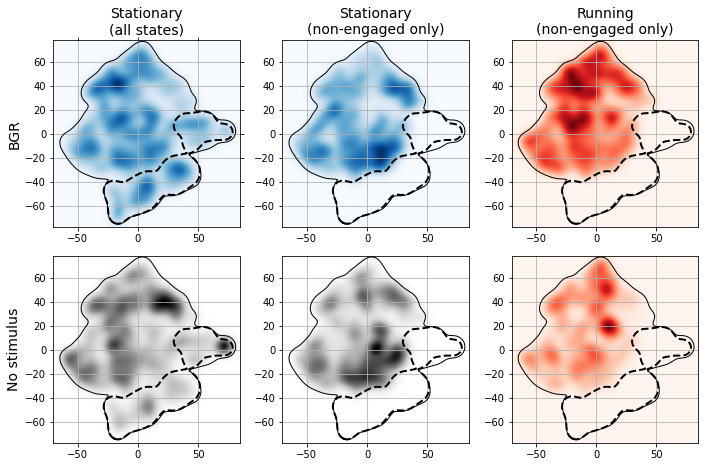

In [52]:
session = '009266_hippoSIT_2023-04-20_08-57-39'

ft, fp = 'tSNE', 70
margin = 5
speed_thresh = 0.04  # m/s
bin_count = 100
#titles = ['Sucessful target', 'Sucessful target', 'Engaged (bE) background', 'Engaged (bE) background / target']
rows, cols = 2, 3

# reading data
animal    = session.split('_')[0]
s_path     = os.path.join(source, animal, session)
bMAP_file = os.path.join(s_path, 'analysis', 'MoSeq_tSNE_UMAP.h5')
with h5py.File(bMAP_file, 'r') as f:
    fit = np.array(f[ft][str(fp)])
with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    events = np.array(f['processed']['sound_events'])

idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
idxs_sil_ev = np.where(events[:, 1] == 0)[0]
idxs_sta_ev = np.where(speed[events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
idxs_run_ev = np.where(speed[events[:, 2].astype(np.int32)] > speed_thresh)[0]

idxs_bgr_sta_ev  = np.intersect1d(idxs_bgr_ev, idxs_sta_ev)
idxs_sil_sta_ev  = np.intersect1d(idxs_sil_ev, idxs_sta_ev)
    
idxs_AL_bgr_sta_ev = s_stats[session]['AL_BGR']
idxs_AL_sil_sta_ev = s_stats[session]['AL_SIL']
idxs_PH_bgr_sta_ev = s_stats[session]['PH_BGR_sta']
idxs_PH_sil_sta_ev = s_stats[session]['PH_SIL_sta']
idxs_PH_bgr_run_ev = s_stats[session]['PH_BGR_run']
idxs_PH_sil_run_ev = s_stats[session]['PH_SIL_run']
    
    
# actual figure    
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.3, rows*3.3))

# fit contours
extent = get_extent(fit, margin=margin)
b_size = extent[1] - extent[0]

# full bMAP fit contours
d_map  = density_map(fit, extent, sigma=sigma, bin_count=100)
levels = np.linspace(0.15*d_map.max(), d_map.max(), 2)
bMAP_fit = axes[0][0].contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)

# bE bMAP fit contours
d_map_AL_bgr_sta = density_map(fit[idxs_AL_bgr_sta_ev], extent, sigma=sigma, bin_count=100)
levels = np.linspace(0.15*d_map_AL_bgr_sta.max(), d_map_AL_bgr_sta.max(), 2)
bMAP_AL_bgr_fit = axes[0][0].contour(d_map_AL_bgr_sta.T, levels, origin='lower', linewidths=2, extent=extent)

d_map_AL_sil_sta = density_map(fit[idxs_AL_sil_sta_ev], extent, sigma=sigma, bin_count=100)
levels = np.linspace(0.15*d_map_AL_sil_sta.max(), d_map_AL_sil_sta.max(), 2)
bMAP_AL_sil_fit = axes[0][0].contour(d_map_AL_sil_sta.T, levels, origin='lower', linewidths=2, extent=extent)

axes[0][0].clear()

# bE - bU
cmaps = ['Blues', 'Greys']
for i, idxs_sel in enumerate([idxs_bgr_sta_ev, idxs_sil_sta_ev]):
    ax = axes[i][0]
    d_map_bgr_sta = density_map(fit[idxs_sel], extent, sigma=sigma, bin_count=bin_count)
    ax.imshow(d_map_bgr_sta.T, cmap=cmaps[i], origin='lower', extent=extent)

# non-bE sta in BGR
cmaps = ['Blues', 'Greys']
for i, idxs_sel in enumerate([idxs_PH_bgr_sta_ev, idxs_PH_sil_sta_ev]):
    ax = axes[i][1]
    d_map_bgr_sta = density_map(fit[idxs_sel], extent, sigma=sigma, bin_count=bin_count)
    ax.imshow(d_map_bgr_sta.T, cmap=cmaps[i], origin='lower', extent=extent)
    
# non-bE sta in BGR
cmaps = ['Reds', 'Reds']
for i, idxs_sel in enumerate([idxs_PH_bgr_run_ev, idxs_PH_sil_run_ev]):
    ax = axes[i][2]
    d_map_bgr_sta = density_map(fit[idxs_sel], extent, sigma=sigma, bin_count=bin_count)
    ax.imshow(d_map_bgr_sta.T, cmap=cmaps[i], origin='lower', extent=extent)
    
for ax in axes.flatten():
    for path in bMAP_fit.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='black', lw=1)
    for path in bMAP_AL_bgr_fit.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='black', lw=2, ls='--')
    ax.grid()
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_aspect('equal')
            
for i, title in enumerate(['Stationary\n(all states)', 'Stationary\n(non-engaged only)', 'Running\n(non-engaged only)']):
    axes[0][i].set_title(title, fontsize=14)
for i, label in enumerate(['BGR', 'No stimulus']):
    axes[i][0].set_ylabel(label, fontsize=14)
    
fig.tight_layout()

In [54]:
fig.savefig(os.path.join(rep_path, '%s_bMAP_bE_bU_run_sta.png' % session[-19:-6]), dpi=300)

### bE - bU difference

In [55]:
s_deltas = {}
for j, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path = os.path.join(source, animal, session)
    
    nmap_file  = os.path.join(s_path, 'analysis', 'nMAP_EV_SU.h5')
    with h5py.File(nmap_file, 'r') as f:
        w_mx = np.array(f['response_manifold'])
        
    deltas_bgr, deltas_sil = [], []
    deltas_bgr_shuf, deltas_sil_shuf = {}, {}
    idxs_AL_bgr = s_stats[session]['AL_BGR']
    idxs_PH_bgr = s_stats[session]['PH_BGR']
    idxs_AL_sil = s_stats[session]['AL_SIL']
    idxs_PH_sil = s_stats[session]['PH_SIL']
    for i in range(w_mx.shape[1]):
        # originals
        deltas_bgr.append(w_mx[idxs_AL_bgr][:, i].mean() - w_mx[idxs_PH_bgr][:, i].mean())
        deltas_sil.append(w_mx[idxs_AL_sil][:, i].mean() - w_mx[idxs_PH_sil][:, i].mean())
        
        # shuffle controls
        for k, idxs_pair in enumerate([(idxs_AL_bgr, idxs_PH_bgr), (idxs_AL_sil, idxs_PH_sil)]):
            deltas_shuf = []
            idxs_st_shuf = np.concatenate([idxs_pair[0], idxs_pair[1]])
            for z in range(100):
                np.random.shuffle(idxs_st_shuf)
                idxs_AL_st_shuf = idxs_st_shuf[:len(idxs_pair[0])]
                idxs_PH_st_shuf = idxs_st_shuf[-len(idxs_pair[1]):]
                deltas_shuf.append(w_mx[idxs_AL_st_shuf][:, i].mean() - w_mx[idxs_PH_st_shuf][:, i].mean())
            if k == 0:
                deltas_bgr_shuf[i] = np.array(deltas_shuf)
            else:
                deltas_sil_shuf[i] = np.array(deltas_shuf)

    s_deltas[session] = {}
    s_deltas[session]['BGR'] = deltas_bgr
    s_deltas[session]['SIL'] = deltas_sil
    s_deltas[session]['BGR_SHUF'] = deltas_bgr_shuf
    s_deltas[session]['SIL_SHUF'] = deltas_sil_shuf
    
    #print(session)

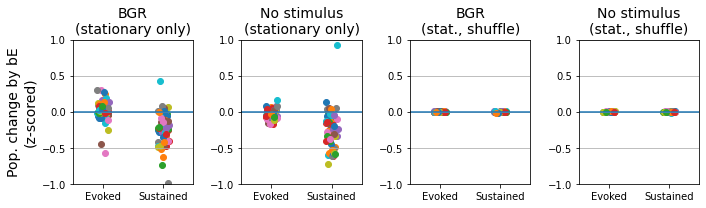

In [56]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3))

titles = ['BGR\n(stationary only)', 'No stimulus\n(stationary only)', \
              'BGR\n(stat., shuffle)', 'No stimulus\n(stat., shuffle)']
for j, s_type in enumerate(['BGR', 'SIL', 'BGR_SHUF', 'SIL_SHUF']):
    ax = axes[j]
    v_max = 0
    for i, (session, deltas_all) in enumerate(s_deltas.items()):
        offset = (np.random.rand(1)[0] - 0.5)*0.2
        if j < 2:
            vals = deltas_all[s_type]
        else:
            vals = np.array([deltas_all[s_type][z].mean() for z in range(2)])
        ax.scatter(np.arange(2) + offset, vals, label=session[-19:-6])
        cv_max = np.abs(np.array(vals)).max()
        if cv_max > v_max:
            v_max = cv_max
    ax.axhline(0)
    ax.grid(axis='y')
    ax.set_ylim(-v_max*1.1, v_max*1.1)
    ax.set_xlim(-0.5, 1.5)
    ax.set_title(titles[j], fontsize=14)
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels(['Evoked', 'Sustained'])
    #ax.set_xlabel('Phase to pulse onset', fontsize=14)
    if j > -1:
        ax.set_ylim(-1, 1)
    #if j == 2:
    #    ax.legend()
    
axes[0].set_ylabel('Pop. change by bE\n(z-scored)', fontsize=14)
fig.tight_layout()

In [58]:
fig.savefig(os.path.join(rep_path, 'bE_bU_cross_session.png'), dpi=300)

### run - sta difference

In [59]:
s_deltas = {}
s_corrs  = {}
for j, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path = os.path.join(source, animal, session)
    meta_file = os.path.join(s_path, 'meta.h5')
    desc_file = os.path.join(s_path, 'descendants.h5')
    nmap_file = os.path.join(s_path, 'analysis', 'nMAP_EV_SU.h5')

    with h5py.File(meta_file, 'r') as f:
        events = np.array(f['processed']['sound_events'])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
    speed_ev = speed[events[:, 2].astype(np.int32)]
        
    # Population activity
    with h5py.File(nmap_file, 'r') as f:
        w_mx = np.array(f['response_manifold'])
    
    deltas_bgr, deltas_sil = [], []
    deltas_bgr_shuf, deltas_sil_shuf = {}, {}
    idxs_PH_bgr_sta = s_stats[session]['PH_BGR_sta']
    idxs_PH_bgr_run = s_stats[session]['PH_BGR_run']
    idxs_PH_sil_sta = s_stats[session]['PH_SIL_sta']
    idxs_PH_sil_run = s_stats[session]['PH_SIL_run']
    corr_PH_bgr_run = []
    corr_PH_sil_run = []
        
    for i in range(2):
        # originals
        deltas_bgr.append(w_mx[idxs_PH_bgr_run][:, i].mean() - w_mx[idxs_PH_bgr_sta][:, i].mean())
        deltas_sil.append(w_mx[idxs_PH_sil_run][:, i].mean() - w_mx[idxs_PH_sil_sta][:, i].mean())
        
        # corr coeff for running periods
        corr, pval = stats.pearsonr(w_mx[idxs_PH_bgr_run][:, i], speed_ev[idxs_PH_bgr_run])
        corr_PH_bgr_run.append([corr, pval])
        corr, pval = stats.pearsonr(w_mx[idxs_PH_sil_run][:, i], speed_ev[idxs_PH_sil_run])
        corr_PH_sil_run.append([corr, pval])
        
        # shuffle controls
        for k, idxs_pair in enumerate([(idxs_PH_bgr_run, idxs_PH_bgr_sta), (idxs_PH_sil_run, idxs_PH_sil_sta)]):
            deltas_shuf = []
            idxs_st_shuf = np.concatenate([idxs_pair[0], idxs_pair[1]])
            for z in range(100):
                np.random.shuffle(idxs_st_shuf)
                idxs_AL_st_shuf = idxs_st_shuf[:len(idxs_pair[0])]
                idxs_PH_st_shuf = idxs_st_shuf[-len(idxs_pair[1]):]
                deltas_shuf.append(w_mx[idxs_AL_st_shuf][:, i].mean() - w_mx[idxs_PH_st_shuf][:, i].mean())
            if k == 0:
                deltas_bgr_shuf[i] = np.array(deltas_shuf)
            else:
                deltas_sil_shuf[i] = np.array(deltas_shuf)

    s_deltas[session] = {}
    s_deltas[session]['BGR'] = deltas_bgr
    s_deltas[session]['SIL'] = deltas_sil
    s_deltas[session]['BGR_SHUF'] = deltas_bgr_shuf
    s_deltas[session]['SIL_SHUF'] = deltas_sil_shuf
    
    s_corrs[session] = {}
    s_corrs[session]['BGR'] = corr_PH_bgr_run
    s_corrs[session]['SIL'] = corr_PH_sil_run
    
    #print(session)

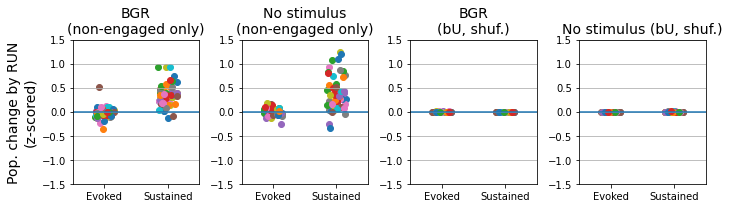

In [64]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3))

titles = ['BGR\n(non-engaged only)', 'No stimulus\n(non-engaged only)', 'BGR\n(bU, shuf.)', 'No stimulus (bU, shuf.)']
for j, s_type in enumerate(['BGR', 'SIL', 'BGR_SHUF', 'SIL_SHUF']):
    ax = axes[j]
    v_max = 0
    for i, (session, deltas_all) in enumerate(s_deltas.items()):
        offset = (np.random.rand(1)[0] - 0.5)*0.3
        if j < 2:
            vals = deltas_all[s_type]
        else:
            vals = np.array([deltas_all[s_type][z].mean() for z in range(2)])
        ax.scatter(np.arange(2) + offset, vals, label=session[-19:-9])
        cv_max = np.abs(np.array(vals)).max()
        if cv_max > v_max:
            v_max = cv_max
    ax.axhline(0)
    ax.grid(axis='y')
    ax.set_ylim(-v_max*1.1, v_max*1.1)
    ax.set_xlim(-0.5, 1.5)
    ax.set_title(titles[j], fontsize=14)
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels(['Evoked', 'Sustained'])
    #if j> 1:
    #    ax.legend()
    ax.set_ylim(-1.5, 1.5)
    
axes[0].set_ylabel('Pop. change by RUN\n(z-scored)', fontsize=14)
fig.tight_layout()

In [65]:
fig.savefig(os.path.join(rep_path, 'run_sta_cross_session.png'), dpi=300)